## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as sp
from tqdm import tqdm
import glob

sys.path.append('../../')
from FaIRv2_0_0_alpha import *
from scripts.data_retrieval import *

%matplotlib inline

In [2]:
## first, import the default parameters:
default_params = pd.read_csv('../../aux/parameter-sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)
param_categories = pd.read_csv('../../aux/FaIRv2.0.0-alpha_RF_categories.csv',index_col=0,skiprows=1,names=['source','category'])

# I. Creation of the FULL perturbed parameter ensemble

Here, we create a one million member perturbed parameters ensemble, intending to span the full range of physically plausible responses within FaIR. These parameters will incorporate uncertainties within the carbon-cycle, radiative forcing & climate response to forcing.

In all cases except for the climate response parameters & aerosol parameters, we will sample scale factors that will be applied to the default parameters.

## Carbon-cycle sampling
We infer the prior carbon cycle parameters from the reduced CMIP6 parameterisations.

In [3]:
cc_CMIP6 = pd.read_csv('../../aux/parameter-sets/CMIP6_cc_reduced.csv',index_col=0).drop('rA')

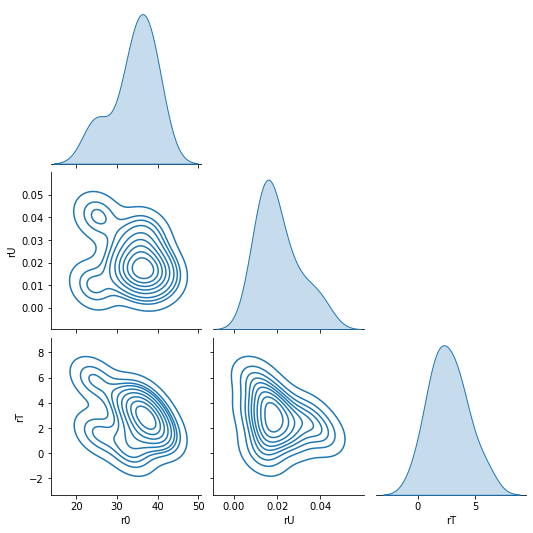

In [4]:
sn.pairplot(cc_CMIP6.T,kind='kde',corner=True)

In [5]:
print(cc_CMIP6.loc['r0'].std()/cc_CMIP6.loc['r0'].mean())
print(np.log(cc_CMIP6.loc['rU']).std())
print(cc_CMIP6.loc['rT'].std()/cc_CMIP6.loc['rT'].mean())

0.15376635375002695
0.44153037029426034
0.6145905509676787


We will sample scale factors, $X$, *independently* as follows:
$$
r_0 \rightarrow X \sim \mathcal{N}(1,0.154)\\
r_U \rightarrow \text{ln}(X) \sim \mathcal{N}(0,0.442)\\
r_T \rightarrow X \sim \mathcal{N}(1,0.615)\\
$$

In [6]:
def get_cc_samples(N,mem_names=False):
    
    if mem_names == False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    r0_sf = sp.stats.norm(1,0.154).rvs(N)
    rU_sf = np.exp(sp.stats.norm(0,0.442).rvs(N))
    rT_sf = sp.stats.norm(1,0.615).rvs(N)
    
    cc_params = default_params.loc['r0':'rT',['carbon_dioxide']].values * np.stack([r0_sf,rU_sf,rT_sf])
    
    return pd.DataFrame(cc_params,index=['r0','rU','rT'],columns=mem_names)

## RF sampling
We construct ensembles of the ERF parameters used in the model by scaling each default ERF parameter by a scaling factor sampled from the appropriate distribution:
$$
\text{CO}_2 \rightarrow X \sim \mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)\\
\text{CH}_4 \rightarrow X \sim \mathcal{N}\left(1,\frac{0.28}{\Phi^{-1}(0.95)}\right)\\
\text{N}_2\text{O} \rightarrow X \sim \mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)\\
\text{other WMGHGs} \rightarrow X \sim \mathcal{N}\left(1,\frac{0.2}{\Phi^{-1}(0.95)}\right)\\
\text{O}_3 \rightarrow X \sim \mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)\\
\text{stratospheric H}_2\text{O from CH}_4 \rightarrow X \sim \mathcal{N}\left(1,\frac{0.72}{\Phi^{-1}(0.95)}\right)\\
\text{BC on snow} \rightarrow \text{ln}(X) \sim \mathcal{N}\left(0,0.457\right)\\
\text{contrails} \rightarrow X \sim \mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)\\
\text{ERFari} \rightarrow X \sim \alpha \text{ parameters drawn from CMIP6 inferred multivariate normal; resulting distribution scaled to match process based assessment in Bellouin (2020)}\\
\text{ERFaci} \rightarrow X \sim \text{parameters drawn independently from CMIP6 inferred distribution; resulting distribtuion scaled to match process based assessment Bellouin (2020)}\\
$$
N.B. the numerator in each normal distribution scale parameter gives the half the 90% confidence interval (ie. uncertainty in CO$_2$ ERF is $\pm20\%$).

In [7]:
forcing_namelist = sorted(return_gas_namelist())

def get_forcing_param_ensemble(N,mem_names = False):

    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]

    rf_sf = {}

    rf_sf['carbon_dioxide'] = sp.stats.norm(1,0.20/1.645)
    rf_sf['methane'] = sp.stats.norm(1,0.28/1.645)
    rf_sf['nitrous_oxide'] = sp.stats.norm(1,0.2/1.645)
    rf_sf['other_wmghgs'] = sp.stats.norm(1,0.20/1.645)
    rf_sf['ozone'] = sp.stats.norm(1,0.5/1.645)
    rf_sf['strat_h2o'] = sp.stats.norm(1,0.72/1.645)
    pct_5 = 0.04 / 0.08 # need to scale by the mean to turn into a "scaling factor"
    pct_95=0.18 / 0.08
    sigma = (np.log(pct_95) - np.log(pct_5)) / (sp.stats.norm().ppf(0.95)-sp.stats.norm().ppf(0.05))
    mu = np.log(pct_5) - sigma * sp.stats.norm().ppf(0.05)
    rf_sf['bc_on_snow'] = sp.stats.lognorm(s=sigma,scale=np.exp(mu))
    rf_sf['contrails'] = sp.stats.norm(1,0.75/1.645)

    # create array to contain the parameters
    f_parameter_ensemble_draw = np.zeros((3,len(forcing_namelist),N))
    default_f_params = default_params.sort_index(axis=1).loc['f1':'f3'].values
    f_parameter_ensemble_draw[:,:,:] = default_f_params[...,None]

    for forc_cat in rf_sf.keys():
        forc_map = (param_categories.sort_index().category==forc_cat)
        f_parameter_ensemble_draw[:,np.arange(81)[forc_map],:] *= rf_sf[forc_cat].rvs(N)[None,None]

    ## draw aerosol parameters based on inferred CMIP6 ranges (see CMIP6_parameter_ranges notebook), then rescaled to match the Bellouin process based assessment

    ## compute parameters, then scale by the Bellouin / 1850-(2005:2015)

    ERFari_params = pd.read_csv('../../aux/parameter-sets/CMIP6_ERFari.csv',index_col=0).sort_index(axis=1)

    ERFari_mean = ERFari_params.mean().values
    ERFari_cov = ERFari_params.cov().values

    ERFari_param_draw = sp.stats.multivariate_normal(ERFari_mean,ERFari_cov).rvs(N)

    ERFaci_params = pd.read_csv('../../aux/parameter-sets/CMIP6_ERFaci.csv',index_col=0)
    ERFaci_params['log_beta'] =  np.log(-1*ERFaci_params['beta'])
    ERFaci_params['log_s'] = np.log(ERFaci_params['s'])
    ERFaci_params['beta_s'] = ERFaci_params['beta'] / ERFaci_params['s']
    ERFaci_params['log_beta_s'] = np.log(-1*ERFaci_params['beta_s'])

    ERFaci_ln_beta_s_cov = ERFaci_params[['log_beta','log_beta_s']].cov().values
    ERFaci_ln_beta_s_mean = ERFaci_params[['log_beta','log_beta_s']].mean().values
    ERFaci_alpha_mean = ERFaci_params['alpha'].mean()
    ERFaci_alpha_std = ERFaci_params['alpha'].std()

    ERFaci_beta_s = np.exp(sp.stats.multivariate_normal(ERFaci_ln_beta_s_mean,ERFaci_ln_beta_s_cov).rvs(N))
    ERFaci_alpha = sp.stats.norm(ERFaci_alpha_mean,ERFaci_alpha_std).rvs(N)
    ERFaci_beta = -1*ERFaci_beta_s[...,0]
    ERFaci_s = ERFaci_beta_s[...,0] / ERFaci_beta_s[...,1]

    ## get aerosol emissions
    RCMIP_aer_emms = RCMIP_to_FaIR_input_emms('ssp245').interpolate().loc[:2019,['bc','oc','so2']]
    ## baseline to be zero in 1750
    RCMIP_aer_emms -= RCMIP_aer_emms.loc[1750]

    ## generate the 1850 - 2010 change
    ERFari_1850_2010 = ((RCMIP_aer_emms.loc[2005:2014].mean() - RCMIP_aer_emms.loc[1850]).values * ERFari_param_draw).sum(axis=1)

    ERFaci_1850_2010 = ERFaci_beta * ( np.log(1 + RCMIP_aer_emms.loc[2005:2014,'so2'].mean()/ERFaci_s) - np.log(1 + RCMIP_aer_emms.loc[1850,'so2'].mean()/ERFaci_s) ) \
    + ERFaci_alpha * (RCMIP_aer_emms.loc[2005:2014,['oc','bc']].mean().sum() - RCMIP_aer_emms.loc[1850,['oc','bc']].sum())

    # Use Nicolas' Ringberg methods
    def uniform1684(a,b,seed,samples=2000):
        interval = (b-a)+((b-a)/(84-16)*32)
        lower = a-((b-a)/(84-16)*16)
        return sp.stats.uniform.rvs(lower, interval, size=samples, random_state=seed)
    samples=N
    dtau    = uniform1684(0.02,0.04,123,samples=samples)
    tau     = uniform1684(0.13,0.17,124,samples=samples)
    S_tau   = uniform1684(-27,-20,125,samples=samples)
    RFari_cloudy = uniform1684(-0.1,0.1,126,samples=samples)
    dR_dRatm = uniform1684(-0.3,-0.1,127,samples=samples)
    dRatm_dtau = uniform1684(17,35,128,samples=samples)
    c_tau    = uniform1684(0.59,0.71,129,samples=samples)
    c_N      = uniform1684(0.19,0.29,130,samples=samples)
    c_L      = uniform1684(0.21,0.29,131,samples=samples)
    c_C      = uniform1684(0.59,1.07,132,samples=samples)
    beta_N_tau = uniform1684(0.3,0.8,133,samples=samples)
    beta_L_N   = uniform1684(-0.36,-0.011,134,samples=samples)
    beta_C_N   = uniform1684(0,0.1,135,samples=samples)
    S_N = uniform1684(-27,-26,136,samples=samples)
    S_L = uniform1684(-56,-54,137,samples=samples)
    S_C = uniform1684(-153,-91,138,samples=samples)

    rfari = dtau*S_tau*(1-c_tau)+RFari_cloudy
    rfari_adj = dtau*dR_dRatm*dRatm_dtau

    dlntau = dtau/tau
    deltan = dlntau * beta_N_tau

    rfaci = dlntau*beta_N_tau*S_N*c_N
    erfaci_L = dlntau*beta_N_tau*beta_L_N*S_L*c_L
    erfaci_C = dlntau*beta_N_tau*beta_C_N*S_C*c_C

    ERFari_scale = rfari + rfari_adj
    ERFaci_scale = rfaci + erfaci_L + erfaci_C

    def np_quantileatscore(a,score):

        return ( (a[:,np.newaxis,...]<score[np.newaxis,...]).sum(axis=0) + (a[:,np.newaxis,...]<=score[np.newaxis,...]).sum(axis=0) ) / (2*a.shape[0])

    ERFari_qmap = (ERFari_scale[np.argsort(ERFari_scale)][(np_quantileatscore(ERFari_1850_2010,ERFari_1850_2010)*N).astype(int)] / ERFari_1850_2010)
    ERFaci_qmap = (ERFaci_scale[np.argsort(ERFaci_scale)][(np_quantileatscore(ERFaci_1850_2010,ERFaci_1850_2010)*N).astype(int)] / ERFaci_1850_2010)

    for i,cat in enumerate(['bc','oc','so2']):
        cat_map = forcing_namelist.index(cat)
        f_parameter_ensemble_draw[1,cat_map,:] = ERFari_param_draw[...,i]*ERFari_qmap

    so2_PI_conc_ensemble = ERFaci_s.copy()

    cat_map = forcing_namelist.index('so2|aci')
    f_parameter_ensemble_draw[0,cat_map,:] = ERFaci_beta*ERFaci_qmap

    cat_map = forcing_namelist.index('oc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha*ERFaci_qmap
    cat_map = forcing_namelist.index('bc|aci')
    f_parameter_ensemble_draw[1,cat_map,:] = ERFaci_alpha*ERFaci_qmap

    gas_parameter_ensemble = pd.concat([default_params.loc[:'emis2conc'].sort_index(axis=1).copy()]*N,axis=1,keys=mem_names)
    
    gas_parameter_ensemble.loc['PI_conc',(slice(None),'so2')] = so2_PI_conc_ensemble[:]
    
    gas_parameter_ensemble = pd.concat([gas_parameter_ensemble,
                                        pd.DataFrame(data=f_parameter_ensemble_draw.swapaxes(1,2).reshape(3,-1)[:],index=['f1','f2','f3'],columns=gas_parameter_ensemble.columns)])
    
#     for i in np.arange(3):
#         gas_parameter_ensemble.loc['f'+str(i+1)] = f_parameter_ensemble_draw[i].T.flatten()

#     gas_parameter_ensemble.loc['f1':'f3',:] = f_parameter_ensemble_draw.swapaxes(1,2).reshape(3,-1)[:]

    

    return gas_parameter_ensemble

## External forcing components

Forcing due to albedo changes (LUC), and natural forcings (volcanic / solar), are exogenously prescribed. We account for uncertainty using the folllowing scaling factors.

- LUC ~ $\mathcal{N}\left(1,\frac{0.75}{\Phi^{-1}(0.95)}\right)$
- volcanic ~ $\mathcal{N}\left(1,\frac{0.5}{\Phi^{-1}(0.95)}\right)$
- solar ~ $\mathcal{N}\left(1,\frac{1}{\Phi^{-1}(0.95)}\right)$

In [8]:
def get_extforc_sfs(N,mem_names=False):
    
    if mem_names == False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
        
    LUC_sfs = sp.stats.norm(1,0.75/1.645).rvs(N)
    volc_sfs = sp.stats.norm(1,0.5/1.645).rvs(N)
    sol_sfs = sp.stats.norm(1,1/1.645).rvs(N)
    
    ext_forc_sfs = pd.DataFrame([LUC_sfs,volc_sfs,sol_sfs],index=['LUC','volc','sol'],columns = mem_names)
    
    return ext_forc_sfs

## Climate response sampling

The prior distributions of climate response parameters are inferred from the CMIP6 tunings.

In [9]:
climresp_CMIP6 = pd.read_csv('../../aux/parameter-sets/CMIP6_climresp.csv',index_col=0,header=[0,1]).stack()
f_params_CMIP6 = pd.read_csv('../../aux/parameter-sets/CMIP6_f_params.csv',index_col=0)
F2x_CMIP6 = f_params_CMIP6.loc['f1']*np.log(2) + f_params_CMIP6.loc['f3'] * (np.sqrt(2*278)-np.sqrt(278))
ECS_CMIP6 = F2x_CMIP6 * climresp_CMIP6.loc['q'].sum()
TCR_CMIP6 = F2x_CMIP6 * ( climresp_CMIP6.loc['q'] * ( 1 - climresp_CMIP6.loc['d']/69.66 * ( 1 - np.exp(-69.66/climresp_CMIP6.loc['d'] ) ) ) ).sum()
RWF_CMIP6 = TCR_CMIP6 / ECS_CMIP6

climresp_CMIP6 = climresp_CMIP6.T
climresp_CMIP6.columns=['d1','d2','d3','q1','q2','q3']

for param in climresp_CMIP6.columns:
    
    climresp_CMIP6['log_'+param] = np.log(climresp_CMIP6[param])
    
climresp_CMIP6['TCR']=TCR_CMIP6
climresp_CMIP6['ECS']=ECS_CMIP6
climresp_CMIP6['RWF']=RWF_CMIP6

We remove the outlying d3 values to prevent the statistics from being messed up.

<AxesSubplot:>

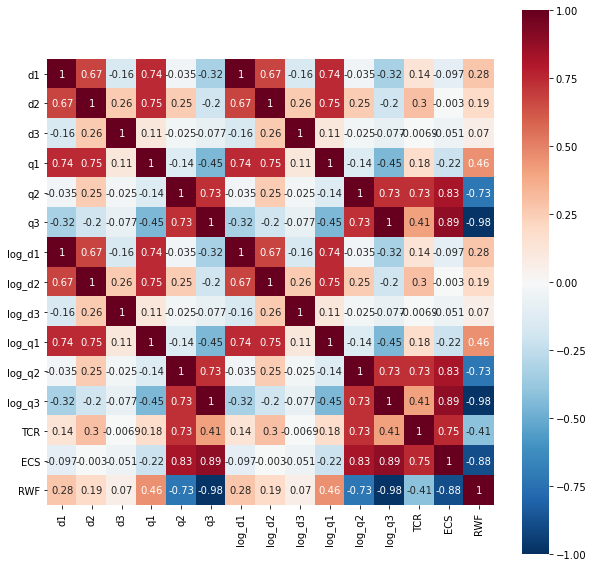

In [10]:
fig=plt.figure(figsize=(10,10))
sn.heatmap(climresp_CMIP6.loc[climresp_CMIP6.log_d3<10].corr(method='spearman'),square=True,annot=True,cmap='RdBu_r',vmin=-1,vmax=1)

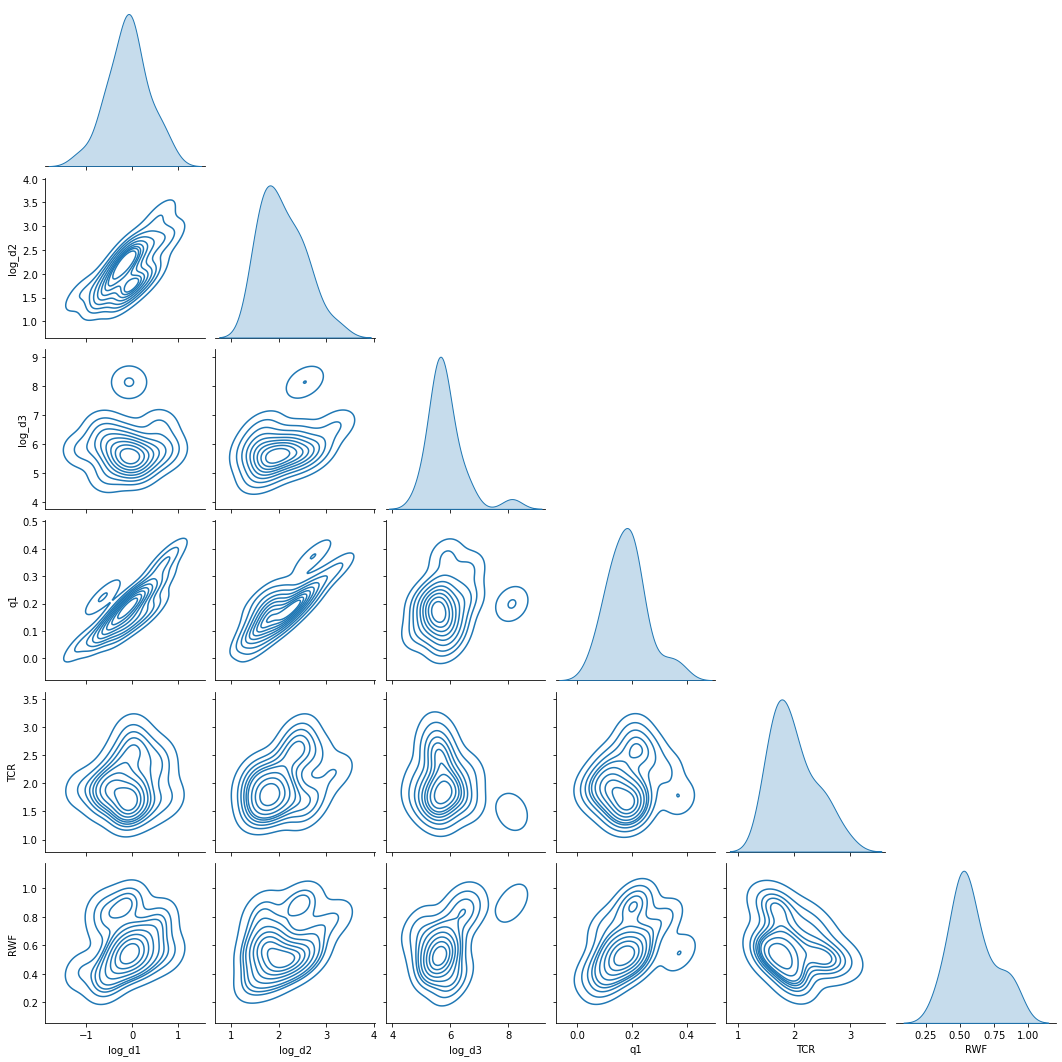

In [11]:
sn.pairplot(climresp_CMIP6.loc[climresp_CMIP6.log_d3<10,['log_d1','log_d2','log_d3','q1','TCR','RWF']],kind='kde',corner=True)

We sample parameters from the following inferred independent distributions:
    
- sample ln_d1, ln_d2, q1 as a multivariate normal
- sample ln_d3 normally
- sample TCR normally
- sample RWF normally

We also create samples for less informed alternative TCR/RWF prior distributions.

In [12]:
def get_response_samples(N,gas_param_ensemble,alternative=False,mem_names=False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]

    cov_mat_1 = climresp_CMIP6.loc[climresp_CMIP6.log_d3<10,['log_d1','log_d2','q1']].cov()
    mean_mat_1 = climresp_CMIP6.loc[climresp_CMIP6.log_d3<10,['log_d1','log_d2','q1']].mean()
    distr_1 = sp.stats.multivariate_normal(mean_mat_1,cov_mat_1)

    ln_d3_distr = sp.stats.norm(climresp_CMIP6.loc[climresp_CMIP6.log_d3<10,'log_d3'].mean(),climresp_CMIP6.loc[climresp_CMIP6.log_d3<10,'log_d3'].std())
    
    if alternative:
        TCR_distr = sp.stats.uniform(0.5,3)
        RWF_distr = sp.stats.uniform(0.2,0.65)
    else:
        TCR_distr = sp.stats.truncnorm(-3,3,2,1/1.645)
        RWF_distr = sp.stats.truncnorm(-3,3,0.55,0.3/1.645)
        
    F_2x = gas_param_ensemble.loc['f1',(slice(None),'carbon_dioxide')].values * np.log(2) + gas_param_ensemble.loc['f3',(slice(None),'carbon_dioxide')].values * (np.sqrt(278*2) - np.sqrt(278))

    lnd1 , lnd2 , q1 , RWF , lnd3 , TCR , ECS , d1, d2, d3 , v1 , v2 , v3 , q2 , q3 = np.empty((15,N))
    
    # we reject samples that correspond to unphysical parameterisations (ie. negative values)
    neg_idx = np.ones(N).astype(bool)
    N_neg = neg_idx.sum()
    
    while N_neg>0:

        lnd1[neg_idx], lnd2[neg_idx], q1[neg_idx] = distr_1.rvs(N_neg).T
        lnd3[neg_idx] = ln_d3_distr.rvs(N_neg)
        
        RWF[neg_idx] = RWF_distr.rvs(N_neg)
        TCR[neg_idx] = TCR_distr.rvs(N_neg)
        
        d1[neg_idx] = np.exp(lnd1[neg_idx])
        d2[neg_idx] = np.exp(lnd2[neg_idx])
        d3[neg_idx] = np.exp(lnd3[neg_idx])
        ECS[neg_idx] = TCR[neg_idx]/RWF[neg_idx]

        v1[neg_idx] = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )[neg_idx]
        v2[neg_idx] = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )[neg_idx]
        v3[neg_idx] = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )[neg_idx]

        q3[neg_idx] = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))[neg_idx]
        q2[neg_idx] = (ECS/F_2x - q1 -  q3)[neg_idx]

        neg_idx = np.any(np.array([d1,d2,d3,q1,q2,q3])<0,axis=0)
        N_neg = neg_idx.sum()
        
    response_par_ensemble = np.array([d1,d2,d3,q1,q2,q3]).T
    thermal_parameter_ensemble = pd.DataFrame(data=response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1),
                                             index=['d','q'],
                                             columns=pd.MultiIndex.from_product([mem_names,[1,2,3]]))
    
    return thermal_parameter_ensemble

## Putting it all together & generating the parameter sets

In [13]:
def create_FULL(N,mem_names=False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
        
    gas_param_ensemble = get_forcing_param_ensemble(N,mem_names)
    
    # draw corresponding FULL & ALTERNATIVE sets
    thermal_param_ensemble_FULL = get_response_samples(N,gas_param_ensemble,False,mem_names)
    thermal_param_ensemble_alt = get_response_samples(N,gas_param_ensemble,True,mem_names)
    
    cc_params = get_cc_samples(N,mem_names=False)
    
    gas_param_ensemble.loc['r0':'rT',(slice(None),'carbon_dioxide')]=cc_params.values
    
    extforc_sfs = get_extforc_sfs(N,mem_names)
    
    return gas_param_ensemble, thermal_param_ensemble_FULL, thermal_param_ensemble_alt, extforc_sfs

We draw 100 sets of 10000 for a total of 1 million sets.

In [14]:
for i in tqdm(np.arange(100)):
    
    mem_names=['mem'+str(x) for x in np.arange(10000*(i),10000*(i+1))]
    
    gas,FULL,ALT,extf = create_FULL(10000,mem_names)
    
    name_suffix = mem_names[0]+'-'+mem_names[-1]
    
    gas.to_hdf(r'../../aux/parameter-sets/perturbed-parameters/gas_params/'+name_suffix+'.h5', key='stage', mode='w')
    FULL.to_hdf(r'../../aux/parameter-sets/perturbed-parameters/climresp_params/FULL/'+name_suffix+'.h5', key='stage', mode='w')
    ALT.to_hdf(r'../../aux/parameter-sets/perturbed-parameters/climresp_params/ALTERNATIVE/'+name_suffix+'.h5', key='stage', mode='w')
    extf.to_hdf(r'../../aux/parameter-sets/perturbed-parameters/extforc_sfs/'+name_suffix+'.h5', key='stage', mode='w')

100%|██████████| 100/100 [07:30<00:00,  4.50s/it]


# II. Running the FULL ensembles over history

Here we carry out 4 historical simulations:
- One FULL including natural forcings
- One FULL excluding natural forcings (this will be used as the constraint sample vs the anthropogenic warming index)
- One ALTERNATIVE including natural forcings
- One ALTERNATIVE excluding natural forcings

#### define a function to map FaIRv2.0.0-alpha output to the desired metrics

In [15]:
## generate desired metrics from the output

def get_metrics(result,thermal_params,gas_params,extforc_sfs,ext_erf):

    _output=[]

    F_2x = (gas_params.loc['f1',(slice(None),'carbon_dioxide')].droplevel(1) * np.log(2) + gas_params.loc['f3',(slice(None),'carbon_dioxide')].droplevel(1) * (np.sqrt(278*2) - np.sqrt(278))).rename('F2xCO2').sort_index()
    ECS = (F_2x*thermal_params.loc['q'].groupby(level=0).sum()).rename('ECS').sort_index()
    TCR = (F_2x*( thermal_params.loc['q'] * (1 - (thermal_params.loc['d']/69.66) * ( 1 - np.exp(-69.66/thermal_params.loc['d']) ) ) ).groupby(level=0).sum()).rename('TCR').sort_index()

    _output += [F_2x,ECS,TCR]

    ## generate baseline temperatures:
    T_1861_1880 = result['T'].loc[1861:1880].mean().rename('T_1861_1880').sort_index()
    T_1861_1880.index = T_1861_1880.index.levels[0]
    T_1850_1900 = result['T'].loc[1850:1900].mean().rename('T_1850_1900').sort_index()
    T_1850_1900.index = T_1850_1900.index.levels[0]
    T_1995_2014 = result['T'].loc[1995:2014].mean().rename('T_1995_2014').sort_index()
    T_1995_2014.index = T_1995_2014.index.levels[0]

    _output += [T_1861_1880,T_1850_1900,T_1995_2014]

    ## generate present-day temperatures & projections
    T_2010_2019 = result['T'].loc[2010:2019].mean().rename('T_2010_2019').sort_index()
    T_2010_2019.index = T_2010_2019.index.levels[0]
    T_2014 = result['T'].loc[2014].rename('T_2014').sort_index()
    T_2014.index = T_2014.index.levels[0]
    T_2100 = result['T'].loc[2100].rename('T_2100').sort_index()
    T_2100.index = T_2100.index.levels[0]
    T_2081_2100 = result['T'].loc[2081:2100].mean().rename('T_2081_2100').sort_index()
    T_2081_2100.index = T_2081_2100.index.levels[0]
    T_peak = result['T'].max().rename('T_peak').sort_index()
    T_peak.index = T_peak.index.levels[0]

    _output += [T_2010_2019,T_2014,T_2100,T_2081_2100,T_peak]

    ## generate present-day temperature rates
    dT_2010_2019  = result['T'].loc[2010:2019].apply(lambda x:sp.stats.linregress(np.arange(10),x).slope).rename('dT_2010_2019').sort_index()
    dT_2010_2019.index = dT_2010_2019.index.levels[0]
    dT_2010_2014  = result['T'].loc[2010:2014].apply(lambda x:sp.stats.linregress(np.arange(5),x).slope).rename('dT_2010_2014').sort_index()
    dT_2010_2014.index = dT_2010_2014.index.levels[0]

    _output += [dT_2010_2019,dT_2010_2014]

    ## compute forcing aggregates
    forc_agg_2019 = result['RF'].loc[2019].unstack().groupby(param_categories.category.to_dict(),axis=1).sum().sort_index()
    forc_agg_2019.columns = [x+'_2019' for x in forc_agg_2019.columns]
    forc_agg_2100 = result['RF'].loc[2100].unstack().groupby(param_categories.category.to_dict(),axis=1).sum().sort_index()
    forc_agg_2100.columns = [x+'_2100' for x in forc_agg_2100.columns]

    LUC_forc_2019 = (extforc_sfs.loc['LUC'] * ext_erf.loc[2019,'land_use']).rename('LUC_2019').sort_index()
    LUC_forc_2100 = (extforc_sfs.loc['LUC'] * ext_erf.loc[2100,'land_use']).rename('LUC_2100').sort_index()

    TOT_forc_2019 = result['RF'].loc[2019].xs('Total',level=1).rename('TOT_2019').sort_index()
    TOT_forc_2100 = result['RF'].loc[2100].xs('Total',level=1).rename('TOT_2100').sort_index()

    _output += [forc_agg_2019,forc_agg_2100,LUC_forc_2019,LUC_forc_2100,TOT_forc_2019,TOT_forc_2100]

    return pd.concat(_output,axis=1)

#### import historical/ssp245 data

In [16]:
## select an ssp to use for the 2015-19 extension
ssp = 'ssp245'

hist_emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[:2100]
## rebase emission-driven forcings to 1750
rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
hist_emms.loc[:,rebase_species] -= hist_emms.loc[1750,rebase_species]

hist_erf = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float).loc[:2100]

#### definition to run the 3 different simulation types

In [17]:
def FULL_runs(mem_range):

    ## load parameter sets:

    gas_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/gas_params/'+mem_range+'.h5')
    thermal_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/climresp_params/FULL/'+mem_range+'.h5')
    extforc_sfs = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/extforc_sfs/'+mem_range+'.h5')

    ## 1. FULL - ALL
    
    ## generate prescribed erf timeseries
    ## dimension is [time,source,mem]
    extforc_arr = (extforc_sfs.values[None] * hist_erf[['land_use','volcanic','solar']].values[...,None])
    extforc_ts=pd.DataFrame(data=extforc_arr.sum(axis=1),index=hist_erf.index,columns=pd.MultiIndex.from_product([extforc_sfs.columns,['forcing']]))

    ## concatenate historical emms into compatible df
    emms_ts = pd.concat([hist_emms.copy()]*extforc_sfs.columns.size,axis=1,keys=extforc_sfs.columns)

    result = run_FaIR(emissions_in=emms_ts,
                    forcing_in=extforc_ts,
                    gas_parameters=gas_params,
                    thermal_parameters=thermal_params,
                      show_run_info=False)
    
    output_FULL_ALL = get_metrics(result,thermal_params,gas_params,extforc_sfs,hist_erf)
    
    ## 2. FULL - ANT
    
    extforc_ts=pd.DataFrame(data=extforc_arr[:,0,:],index=hist_erf.index,columns=pd.MultiIndex.from_product([extforc_sfs.columns,['forcing']]))
    
    result = run_FaIR(emissions_in=emms_ts,
                    forcing_in=extforc_ts,
                    gas_parameters=gas_params,
                    thermal_parameters=thermal_params,
                      show_run_info=False)
    
    output_FULL_ANT = get_metrics(result,thermal_params,gas_params,extforc_sfs,hist_erf)
    
    ## 3. ALT - ALL
    
    thermal_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/climresp_params/ALTERNATIVE/'+mem_range+'.h5')
    extforc_ts=pd.DataFrame(data=extforc_arr.sum(axis=1),index=hist_erf.index,columns=pd.MultiIndex.from_product([extforc_sfs.columns,['forcing']]))
    
    result = run_FaIR(emissions_in=emms_ts,
                    forcing_in=extforc_ts,
                    gas_parameters=gas_params,
                    thermal_parameters=thermal_params,
                      show_run_info=False)
    
    output_ALT_ALL = get_metrics(result,thermal_params,gas_params,extforc_sfs,hist_erf)
    
    ## 4. ALT - ANT
    
    extforc_ts=pd.DataFrame(data=extforc_arr[:,0,:],index=hist_erf.index,columns=pd.MultiIndex.from_product([extforc_sfs.columns,['forcing']]))
    
    result = run_FaIR(emissions_in=emms_ts,
                    forcing_in=extforc_ts,
                    gas_parameters=gas_params,
                    thermal_parameters=thermal_params,
                      show_run_info=False)
    
    output_ALT_ANT = get_metrics(result,thermal_params,gas_params,extforc_sfs,hist_erf)
    
    return output_FULL_ALL,output_FULL_ANT,output_ALT_ALL,output_ALT_ANT

#### run the simulations!

In [18]:
ALL_mems = [x.split('/')[-1].split('.')[0] for x in glob.glob('../../aux/parameter-sets/perturbed-parameters/gas_params/*.h5')]
# test_mems = ['mem0-mem9999','mem10000-mem19999']

FULL_ALL=[]
FULL_ANT=[]
ALT_ALL=[]
ALT_ANT=[]

for mem_range in ALL_mems:
    print('computing metrics for '+mem_range)
    results = FULL_runs(mem_range)
    
    FULL_ALL+= [results[0]]
    FULL_ANT+= [results[1]]
    ALT_ALL+= [results[2]]
    ALT_ANT+= [results[3]]
    
FULL_ALL = pd.concat(FULL_ALL)
FULL_ANT = pd.concat(FULL_ANT)
ALT_ALL = pd.concat(ALT_ALL)
ALT_ANT = pd.concat(ALT_ANT)

computing metrics for mem510000-mem519999


100%|██████████| 350/350 [00:28<00:00, 12.11 timestep/s]


computing metrics for mem920000-mem929999


100%|██████████| 350/350 [00:24<00:00, 14.48 timestep/s]


computing metrics for mem210000-mem219999


100%|██████████| 350/350 [00:23<00:00, 14.73 timestep/s]


computing metrics for mem710000-mem719999


100%|██████████| 350/350 [00:24<00:00, 14.22 timestep/s]


computing metrics for mem960000-mem969999


100%|██████████| 350/350 [00:24<00:00, 14.24 timestep/s]


computing metrics for mem50000-mem59999


100%|██████████| 350/350 [00:24<00:00, 14.14 timestep/s]


computing metrics for mem30000-mem39999


100%|██████████| 350/350 [00:23<00:00, 14.78 timestep/s]


computing metrics for mem440000-mem449999


100%|██████████| 350/350 [00:23<00:00, 14.73 timestep/s]


computing metrics for mem650000-mem659999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem860000-mem869999


100%|██████████| 350/350 [00:23<00:00, 14.73 timestep/s]


computing metrics for mem80000-mem89999


100%|██████████| 350/350 [00:23<00:00, 14.62 timestep/s]


computing metrics for mem800000-mem809999


100%|██████████| 350/350 [00:23<00:00, 14.77 timestep/s]


computing metrics for mem70000-mem79999


100%|██████████| 350/350 [00:23<00:00, 14.82 timestep/s]


computing metrics for mem40000-mem49999


100%|██████████| 350/350 [00:23<00:00, 14.78 timestep/s]


computing metrics for mem350000-mem359999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem910000-mem919999


100%|██████████| 350/350 [00:23<00:00, 14.86 timestep/s]


computing metrics for mem240000-mem249999


100%|██████████| 350/350 [00:22<00:00, 15.41 timestep/s]


computing metrics for mem900000-mem909999


100%|██████████| 350/350 [00:22<00:00, 15.71 timestep/s]


computing metrics for mem450000-mem459999


100%|██████████| 350/350 [00:22<00:00, 15.67 timestep/s]


computing metrics for mem890000-mem899999


100%|██████████| 350/350 [00:22<00:00, 15.74 timestep/s]


computing metrics for mem330000-mem339999


100%|██████████| 350/350 [00:22<00:00, 15.45 timestep/s]


computing metrics for mem640000-mem649999


100%|██████████| 350/350 [00:24<00:00, 14.45 timestep/s]


computing metrics for mem680000-mem689999


100%|██████████| 350/350 [00:23<00:00, 14.70 timestep/s]


computing metrics for mem280000-mem289999


100%|██████████| 350/350 [00:23<00:00, 14.85 timestep/s]


computing metrics for mem570000-mem579999


100%|██████████| 350/350 [00:23<00:00, 14.76 timestep/s]


computing metrics for mem560000-mem569999


100%|██████████| 350/350 [00:23<00:00, 14.82 timestep/s]


computing metrics for mem730000-mem739999


100%|██████████| 350/350 [00:23<00:00, 14.76 timestep/s]


computing metrics for mem660000-mem669999


100%|██████████| 350/350 [00:23<00:00, 14.78 timestep/s]


computing metrics for mem260000-mem269999


100%|██████████| 350/350 [00:23<00:00, 14.71 timestep/s]


computing metrics for mem930000-mem939999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem490000-mem499999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem200000-mem209999


100%|██████████| 350/350 [00:23<00:00, 14.77 timestep/s]


computing metrics for mem380000-mem389999


100%|██████████| 350/350 [00:23<00:00, 14.77 timestep/s]


computing metrics for mem220000-mem229999


100%|██████████| 350/350 [00:23<00:00, 14.83 timestep/s]


computing metrics for mem230000-mem239999


100%|██████████| 350/350 [00:23<00:00, 14.59 timestep/s]


computing metrics for mem120000-mem129999


100%|██████████| 350/350 [00:23<00:00, 14.78 timestep/s]


computing metrics for mem980000-mem989999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem150000-mem159999


100%|██████████| 350/350 [00:23<00:00, 14.76 timestep/s]


computing metrics for mem390000-mem399999


100%|██████████| 350/350 [00:23<00:00, 14.77 timestep/s]


computing metrics for mem360000-mem369999


100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


computing metrics for mem290000-mem299999


100%|██████████| 350/350 [00:23<00:00, 14.79 timestep/s]


computing metrics for mem320000-mem329999


100%|██████████| 350/350 [00:23<00:00, 14.75 timestep/s]


computing metrics for mem990000-mem999999


100%|██████████| 350/350 [00:23<00:00, 14.74 timestep/s]


computing metrics for mem760000-mem769999


100%|██████████| 350/350 [00:23<00:00, 15.09 timestep/s]


computing metrics for mem190000-mem199999


100%|██████████| 350/350 [00:22<00:00, 15.51 timestep/s]


computing metrics for mem470000-mem479999


100%|██████████| 350/350 [00:22<00:00, 15.70 timestep/s]


computing metrics for mem590000-mem599999


100%|██████████| 350/350 [00:22<00:00, 15.49 timestep/s]


computing metrics for mem870000-mem879999


100%|██████████| 350/350 [00:22<00:00, 15.66 timestep/s]


computing metrics for mem410000-mem419999


100%|██████████| 350/350 [00:22<00:00, 15.61 timestep/s]


computing metrics for mem940000-mem949999


100%|██████████| 350/350 [00:22<00:00, 15.43 timestep/s]


computing metrics for mem100000-mem109999


100%|██████████| 350/350 [00:22<00:00, 15.70 timestep/s]


computing metrics for mem0-mem9999


100%|██████████| 350/350 [00:22<00:00, 15.66 timestep/s]


computing metrics for mem160000-mem169999


100%|██████████| 350/350 [00:22<00:00, 15.68 timestep/s]


computing metrics for mem740000-mem749999


100%|██████████| 350/350 [00:22<00:00, 15.66 timestep/s]


computing metrics for mem600000-mem609999


100%|██████████| 350/350 [00:22<00:00, 15.69 timestep/s]


computing metrics for mem880000-mem889999


100%|██████████| 350/350 [00:22<00:00, 15.57 timestep/s]


computing metrics for mem830000-mem839999


100%|██████████| 350/350 [00:22<00:00, 15.66 timestep/s]


computing metrics for mem430000-mem439999


100%|██████████| 350/350 [00:22<00:00, 15.68 timestep/s]


computing metrics for mem610000-mem619999


100%|██████████| 350/350 [00:22<00:00, 15.68 timestep/s]


computing metrics for mem90000-mem99999


100%|██████████| 350/350 [00:23<00:00, 15.18 timestep/s]


computing metrics for mem840000-mem849999


100%|██████████| 350/350 [00:22<00:00, 15.64 timestep/s]


computing metrics for mem460000-mem469999


100%|██████████| 350/350 [00:22<00:00, 15.71 timestep/s]


computing metrics for mem670000-mem679999


100%|██████████| 350/350 [00:23<00:00, 14.82 timestep/s]


computing metrics for mem810000-mem819999


100%|██████████| 350/350 [00:22<00:00, 15.70 timestep/s]


computing metrics for mem700000-mem709999


100%|██████████| 350/350 [00:22<00:00, 15.61 timestep/s]


computing metrics for mem770000-mem779999


100%|██████████| 350/350 [00:22<00:00, 15.67 timestep/s]


computing metrics for mem820000-mem829999


100%|██████████| 350/350 [00:22<00:00, 15.66 timestep/s]


computing metrics for mem20000-mem29999


100%|██████████| 350/350 [00:22<00:00, 15.72 timestep/s]


computing metrics for mem250000-mem259999


100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


computing metrics for mem480000-mem489999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem340000-mem349999


100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


computing metrics for mem180000-mem189999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem300000-mem309999


100%|██████████| 350/350 [00:23<00:00, 14.75 timestep/s]


computing metrics for mem790000-mem799999


100%|██████████| 350/350 [00:23<00:00, 14.86 timestep/s]


computing metrics for mem130000-mem139999


100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


computing metrics for mem140000-mem149999


100%|██████████| 350/350 [00:23<00:00, 14.86 timestep/s]


computing metrics for mem520000-mem529999


100%|██████████| 350/350 [00:23<00:00, 14.86 timestep/s]


computing metrics for mem400000-mem409999


100%|██████████| 350/350 [00:23<00:00, 14.77 timestep/s]


computing metrics for mem850000-mem859999


100%|██████████| 350/350 [00:23<00:00, 14.83 timestep/s]


computing metrics for mem720000-mem729999


100%|██████████| 350/350 [00:23<00:00, 14.79 timestep/s]


computing metrics for mem580000-mem589999


100%|██████████| 350/350 [00:23<00:00, 14.87 timestep/s]


computing metrics for mem750000-mem759999


100%|██████████| 350/350 [00:23<00:00, 14.85 timestep/s]


computing metrics for mem110000-mem119999


100%|██████████| 350/350 [00:23<00:00, 14.76 timestep/s]


computing metrics for mem500000-mem509999


100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


computing metrics for mem270000-mem279999


100%|██████████| 350/350 [00:23<00:00, 14.83 timestep/s]


computing metrics for mem60000-mem69999


100%|██████████| 350/350 [00:23<00:00, 14.83 timestep/s]


computing metrics for mem170000-mem179999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem540000-mem549999


100%|██████████| 350/350 [00:23<00:00, 14.67 timestep/s]


computing metrics for mem370000-mem379999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem970000-mem979999


100%|██████████| 350/350 [00:23<00:00, 14.84 timestep/s]


computing metrics for mem420000-mem429999


100%|██████████| 350/350 [00:23<00:00, 14.85 timestep/s]


computing metrics for mem690000-mem699999


100%|██████████| 350/350 [00:23<00:00, 14.79 timestep/s]


computing metrics for mem550000-mem559999


100%|██████████| 350/350 [00:23<00:00, 14.87 timestep/s]


computing metrics for mem630000-mem639999


100%|██████████| 350/350 [00:23<00:00, 14.82 timestep/s]


computing metrics for mem950000-mem959999


100%|██████████| 350/350 [00:23<00:00, 14.88 timestep/s]


computing metrics for mem780000-mem789999


100%|██████████| 350/350 [00:23<00:00, 14.81 timestep/s]


computing metrics for mem10000-mem19999


100%|██████████| 350/350 [00:23<00:00, 14.82 timestep/s]


computing metrics for mem310000-mem319999


100%|██████████| 350/350 [00:23<00:00, 14.77 timestep/s]


computing metrics for mem530000-mem539999


100%|██████████| 350/350 [00:23<00:00, 14.86 timestep/s]


computing metrics for mem620000-mem629999


100%|██████████| 350/350 [00:23<00:00, 14.82 timestep/s]


In [19]:
# save results!
FULL_ALL.sort_index().to_hdf(r'../../aux/parameter-sets/perturbed-parameters/FULL_ALL.h5', key='stage', mode='w')
FULL_ANT.sort_index().to_hdf(r'../../aux/parameter-sets/perturbed-parameters/FULL_ANT.h5', key='stage', mode='w')
ALT_ALL.sort_index().to_hdf(r'../../aux/parameter-sets/perturbed-parameters/ALT_ALL.h5', key='stage', mode='w')
ALT_ANT.sort_index().to_hdf(r'../../aux/parameter-sets/perturbed-parameters/ALT_ANT.h5', key='stage', mode='w')

# III. Running the FULL ensemble over the SSPs

Same as above, but FULL / ALL-forc run only over all the SSPs.

Note for this to work you need to run the cell that defines `get_metrics` (first cell of code after **II.**).

In [20]:
ALL_mems = sorted([x.split('/')[-1].split('.')[0] for x in glob.glob('../../aux/parameter-sets/perturbed-parameters/gas_params/*.h5')])
# test_mems = ['mem0-mem9999','mem10000-mem19999']

for ssp in ['ssp119','ssp126','ssp245','ssp370','ssp370-lowNTCF-aerchemmip','ssp370-lowNTCF-gidden','ssp434','ssp460','ssp534-over','ssp585']:
    print('computing metrics for '+ssp)
    
    ssp_emms = RCMIP_to_FaIR_input_emms(ssp).interpolate().loc[:2100]
    ## rebase emission-driven forcings to 1750
    rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
    ssp_emms.loc[:,rebase_species] -= ssp_emms.loc[1750,rebase_species]

    ssp_erf = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+ssp+'_1750-2500.csv',index_col=0,dtype=float).loc[:2100]
    
    ssp_results = []

    for mem_range in ALL_mems:

        ## load parameter sets:
        gas_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/gas_params/'+mem_range+'.h5')
        thermal_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/climresp_params/FULL/'+mem_range+'.h5')
        extforc_sfs = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/extforc_sfs/'+mem_range+'.h5')

        ## generate prescribed erf timeseries
        ## dimension is [time,source,mem]
        extforc_arr = (extforc_sfs.values[None] * ssp_erf[['land_use','volcanic','solar']].values[...,None])
        extforc_ts = pd.DataFrame(data=extforc_arr.sum(axis=1),index=ssp_erf.index,columns=pd.MultiIndex.from_product([extforc_sfs.columns,['forcing']]))

        ## concatenate historical emms into compatible df
        emms_ts = pd.concat([ssp_emms.copy()]*extforc_sfs.columns.size,axis=1,keys=extforc_sfs.columns)

        result = run_FaIR(emissions_in=emms_ts,
                        forcing_in=extforc_ts,
                        gas_parameters=gas_params,
                        thermal_parameters=thermal_params,
                          show_run_info=False)

        ssp_results += [get_metrics(result,thermal_params,gas_params,extforc_sfs,ssp_erf)]
        
    pd.concat(ssp_results).sort_index().to_hdf(r'../../aux/parameter-sets/perturbed-parameters/'+ssp+'.h5', key='stage', mode='w')

computing metrics for ssp119


100%|██████████| 350/350 [00:22<00:00, 15.69 timestep/s]


computing metrics for ssp126


100%|██████████| 350/350 [00:23<00:00, 15.12 timestep/s]


computing metrics for ssp245


100%|██████████| 350/350 [00:23<00:00, 14.72 timestep/s]


computing metrics for ssp370


100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


computing metrics for ssp370-lowNTCF-aerchemmip


100%|██████████| 350/350 [00:22<00:00, 15.61 timestep/s]


computing metrics for ssp370-lowNTCF-gidden


100%|██████████| 350/350 [00:23<00:00, 14.80 timestep/s]


computing metrics for ssp434


100%|██████████| 350/350 [00:27<00:00, 12.80 timestep/s]


computing metrics for ssp460


100%|██████████| 350/350 [00:26<00:00, 13.06 timestep/s]


computing metrics for ssp534-over


100%|██████████| 350/350 [00:23<00:00, 15.05 timestep/s]


computing metrics for ssp585


100%|██████████| 350/350 [00:27<00:00, 12.92 timestep/s]
